Investigation of [airplane crashes dataset](https://www.kaggle.com/saurograndi/airplane-crashes-since-1908)

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.basemap import Basemap
%matplotlib inline

from datetime import datetime

In [3]:
df = pd.DataFrame.from_csv("data/3-Airplane_Crashes_Since_1908.txt", index_col=None)

Removing some fields (one I do not want to investigate, may be there is something intersting there)

In [4]:
df.drop(['Flight #', 'Registration', 'cn/In', 'Ground', 'Time'], axis=1, inplace=True)

Number of planes crashed per year.

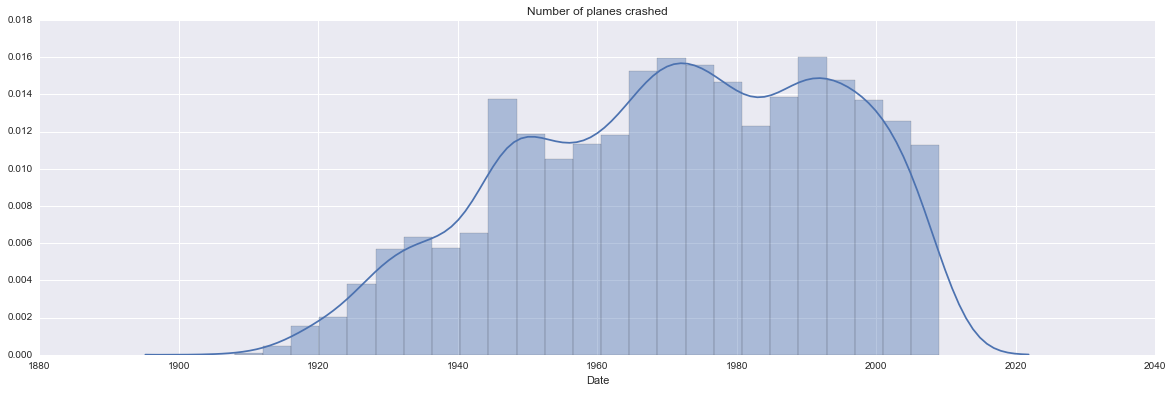

In [5]:
plt.figure(figsize=(20, 6))
plot_ = sns.distplot(df['Date'].apply(lambda x: int(x.split('/')[-1])))
plt.title("Number of planes crashed")

Number of people died per year.

(1908, 2009)

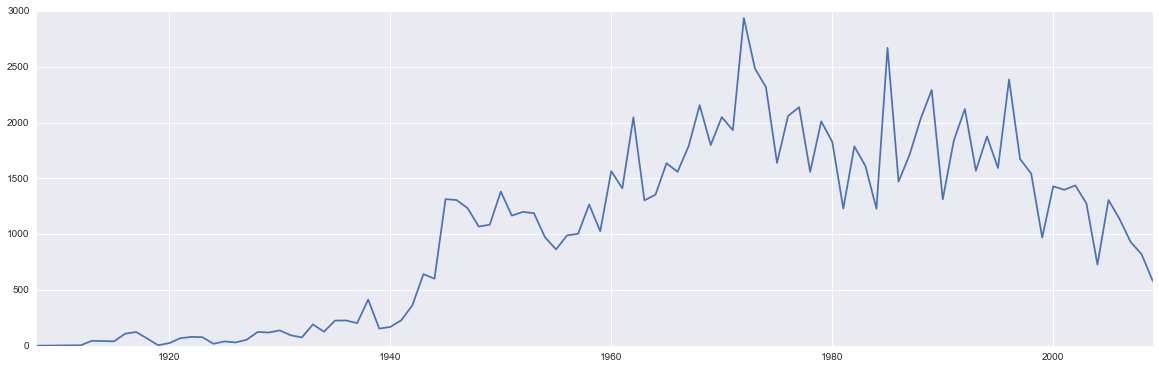

In [6]:
df_tmp = df[['Date', 'Fatalities']].copy()
df_tmp['year'] = df_tmp['Date'].apply(lambda x: int(x.split('/')[-1]))

plt.figure(figsize=(20, 6))
plt.plot(df_tmp.groupby('year').sum())
plt.xlim([1908, 2009])

It looks like the maximum number of deaths happend approximately in 1972. After 1990 the number of fatalities started to decline. We do not have the number of total amount of people travelled each year, but this number is clearly increasing. So it looks like the probability of dying in a plane crash significantly decreases.

----
Now let's see whether the number of deaths per different day is somehow different.

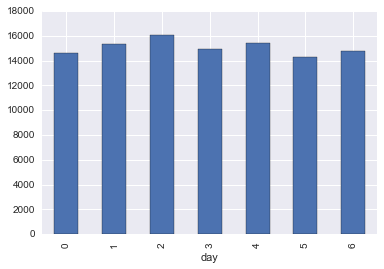

In [17]:
df_tmp['day'] = df_tmp['Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').weekday())
df_tmp.groupby('day').sum()['Fatalities'].plot('bar')

Here 0 is Monday, 6 is Sunday. Nothing interesting, number of poeple died in each day is approximately the same.

------

Now let's investigate type of airplains crashed the most. There are many different planes there, so some preprocessing will be needed. Analyzing `df['Type'].str.lower().value_counts()` I selected found the following common types.

douglas      1111
OTHER         415
boeing        371
lockheed      339
cessna        302
havilland     301
antonov       248
beech         162
curtiss       134
fokker        133
Name: plane_type, dtype: int64


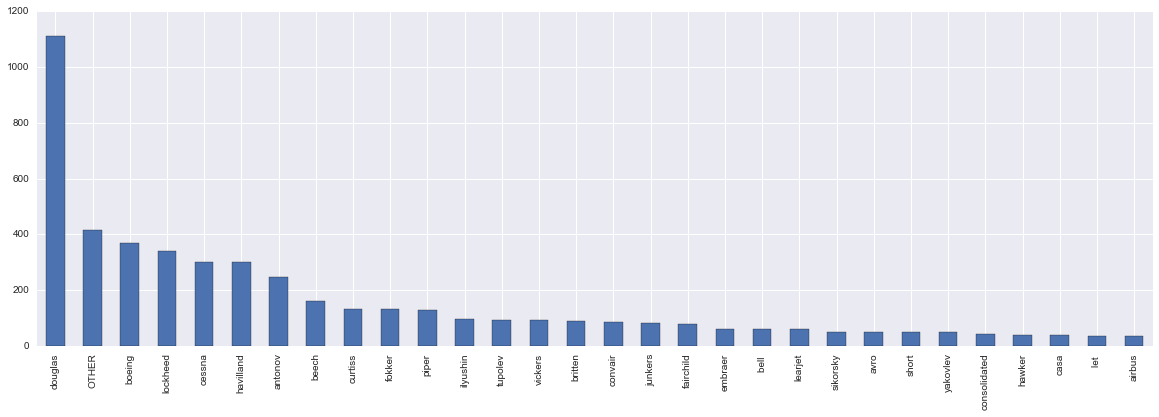

In [8]:
def type_extractor(x):
    plane_types = [
        'douglas', 'havilland', 'antonov', 'yakovlev', 'junkers', 'breguet', 'curtiss', 'embraer',
        'fokker', 'tupolev', 'lockheed', 'cessna', 'boeing', 'piper', 'britten', 'ilyushin', 'airship',
        'sikorsky', 'bristol', 'casa', 'convair', 'vickers', 'fairchild', 'consolidated', 'hawker', 'let ',
        'mil ', 'martin', 'airbus', 'bell ', 'learjet', 'avro', 'short', 'aerospatiale', 'beech', 'swearingen', 
        'british aerospace', 'canadair', 'farman ', 'aero commander', 'bac ',
        'dornier', 'ford', 'grumman', 'handley', 'latecoere', 'mi-', 'rockwell', 'sud'
    ]
    for name in plane_types:
        if name in x:
            return name
    return 'OTHER'

df['Type'].fillna('not_known', inplace=True)
df['Type'] = df['Type'].str.lower()
df['plane_type'] = df['Type'].apply(type_extractor)

plt.figure(figsize=(20, 6))
df['plane_type'].value_counts()[:30].plot('bar')
print df['plane_type'].value_counts()[:10]

As far as we see, Douglass has an owerwhelming 1111 number of crashes. It makes sense to read about each types of the ariplanse that we see in this plot.

I do not think that it is intersting to investigate `Operator`. They change often in 100 years. Also I do not think that `Route` is interesting (also one can extract `from-to` relationship and plot them on the map). For me it would be interesting to see the following things:

 - what caused the crash
 - plot the places of crash on the map
 
To investigate what caused a crash, I will need to do some text-processing on the `Summary` field. I will not do anything hard, will just look for something related to:
 - weather
 - lost control
 - crash at landing
 - crash at taking off
 - collision in the air
 - so on
 
This analysis is pretty unreliable, so should not be trusted

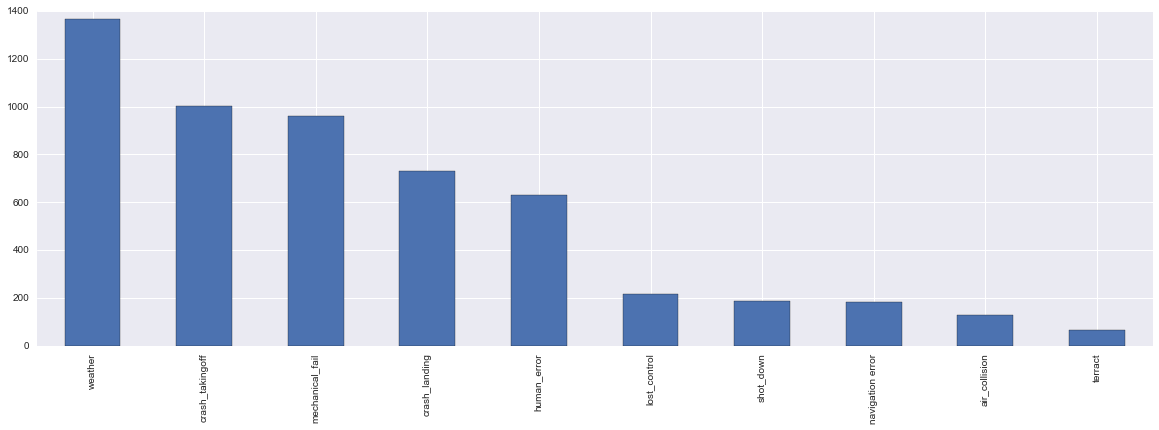

In [9]:
def investigate(s):
    data = {
        'weather': [
            'fog', ' rain', 'unlighted', 'thunder', 'turbulence', 'air pocket', 'adverse weather', 
            'mist', 'weather conditions', 'storm', 'typhoon', 'icing', 'bad weather', 'poor weather',
            'meteorological conditions', 'head wind', 'lightning', 'weather was poor', 'snow',
            'weather related', ' ice'
        ],
        'lost_control': ['disorientation', 'low altitude', 'loss of control'],
        'crash_landing': ['short of the runway', 'attempting to land', 'on approach', 'final approach'],
        'crash_takingoff': ['taking off', 'takeoff', 'take off'],
        'air_collision': ['mid-air', 'in-flight collision', 'midair', 'planes collided'],
        'shot_down': ['shot down', 'missile', 'rebel', 'fighter'],
        'mechanical_fail': [
            'engine', 'propeller', 'mechanical failure', 'rotor', 'out of fuel', 'system failure', 'component failure',
            'fatigue'
        ],
        'navigation error': [
            'navigational error', 'disoriented', 'altimiter', 'poor visibility', 'altimeter',
            'compass', 'gyros', 'navigational equipment', 'erroneous navigation'
        ],
        'human_error': [
            'failure of the crew', 'pilot error', 'did not follow', 'crew ignored', 'failure to', 
            'delayed landing', 'overloaded', 'misinterpretation', 'misjudge', 'failed to', 'lost control', 
            'inadequate risk', 'improper use', 'midjudge', 'poor crew'
        ],
        'terract': ['bomb', 'hijacker']
    }

    res = []
    for el, words in data.iteritems():
        res += [el for word in words if word in s]
        
    return list(set(res))

df['Summary'].fillna('', inplace=True)
all_values = []
for s in df['Summary']:
    all_values += investigate(s.lower())

plt.figure(figsize=(20, 6))
pd.DataFrame(all_values)[0].value_counts().plot('bar')

From this we see that weather conditions is the most frequent reason for a crash, then follow crash while taking off, mechanical failure and landing. Terract is the most unlikely incident.

-----

To find where the plane has crashed, I will need to parse data from `Location` and feed it to some API that takes a place and returns a coordinate. I am not looking for anything precise because locations often show a huge region (North Sea).

This can be done by using [Google API](https://developers.google.com/maps/documentation/geocoding/start).

Because it will take a lot of time and most probably Kaggle does not allow to make http requests (for security reasons), I will just post all the locations I extracted. Also Google API allows you to do only 2500 free reqeusts, so you will not be able to extract all values. I extracted them for the first 2k+ points and here they are.

In [10]:
import requests
from urllib import urlencode
import time

def getLatLng(s, attempt=0):
    time.sleep(1)
    r = requests.get('http://maps.googleapis.com/maps/api/geocode/json', params=urlencode({'address': s}))
    if r.status_code != 200:
        return 0, 0
    
    tmp = r.json()
    print tmp
    if tmp['status'] == 'OVER_QUERY_LIMIT':
        raise Exception("Over Query Limit")
    
    if tmp['status'] == 'ZERO_RESULTS':
        if attempt == 0:
            return getLatLng(s.split(',')[-1], 1)
        else:
            return 0, 0

    loc = tmp['results'][0]['geometry']['location']
    return loc['lat'], loc['lng']
    
def cleanLocation(s):
    for prefix in ['Near ', 'Off ', 'Over the ']:
        if s.startswith(prefix):
            return s[len(prefix):]
    return s

# df['Location'].fillna('', inplace=True)
# can_work = False
# for s in df['Location']:
#     if can_work:
#         if s:
#             print s,
#             lat_lng = getLatLng(cleanLocation(s))
#             print lat_lng 
#             locs.append(lat_lng)
#     else:
#         if s == 'Merida, Venezuela':
#             print s,
#             can_work = True
#             lat_lng = getLatLng(cleanLocation(s))
#             print lat_lng 
#             locs.append(lat_lng)

In [11]:
locs = [(38.883541, -77.0810889), (39.3642834, -74.4229266), (48.4284207, -123.3656444), (56.511018, 3.515625), (50.2074306, 11.2858917), (50.81057, 4.93622), (53.859336, 8.6879057), (42.48419990000001, 26.5035023), (51.627903, 0.418397), (51.696636, -0.175948), (49.9928617, 8.2472526), (54.691745, -1.212926), (51.0543422, 3.7174243), (50.9415388, 6.9565985), (56.511018, 3.515625), (53.25018439999999, 4.9514271), (45.567631, -92.509514), (48.592237, 6.492338999999999), (28.080721, -81.516285), (53.3641829, 13.0532149), (53.44056399999999, 5.6587659), (40.6639916, -74.2107006), (41.49932, -81.6943605), (40.9064, -77.9395179), (54.978252, -1.61778), (39.2720509, -76.73191609999999), (50.134664, -0.357056), (40.78593310000001, -74.7801645), (41.5033572, -85.8307059), (40.735657, -74.1723667), (40.735657, -74.1723667), (40.0583238, -74.4056612), (41.2916728, -92.6493595), (41.49932, -81.6943605), (52.1359729, -0.4666546), (38.9896967, -76.93776), (40.79676670000001, -74.4815438), (41.4108855, -83.46104), (40.5395289, -76.96081029999999), (42.518487, 3.106592), (39.4699075, -0.3762881), (41.8500284, -88.3125738), (41.0802621, -105.5074905), (51.555684, -0.21396), (41.3850639, 2.1734035), (44.8871878, -93.1643869), (43.8013556, -91.23958069999999), (36.140751, -5.353585), (40.8324211, -115.7631232), (-37.9178086, 144.7477259), (40.7339981, -73.59551499999999), (41.49932, -81.6943605), (41.58746439999999, -109.2029043), (37.7749295, -122.4194155), (43.604652, 1.444209), (53.745365, -0.2956928), (48.856614, 2.3522219), (-36.6016558, 145.2195321), (48.856614, 2.3522219), (36.8507689, -76.28587259999999), (49.665342, 1.939705), (39.206062, 115.04908), (53.411758, -2.317364), (51.081397, 1.169456), (36.5270612, -6.2885962), (39.768403, -86.158068), (45.4408474, 12.3155151), (35.1744271, -6.1473964), (34.0181246, -5.0078451), (41.919229, 8.738635), (41.3850639, 2.1734035), (41.1399814, -104.8202462), (41.6414438, -80.15144839999999), (49.70958, 2.17198), (44.4267674, 26.1025384), (41.4645824, -83.9521687), (51.4308255, -1.1444927), (61.52401, 105.318756), (41.4000523, -82.80852039999999), (34.5531284, 18.0480105), (41.1697041, -104.2568991), (40.9658931, -78.6130821), (50.134664, -0.357056), (11.0041072, -74.80698129999999), (37.09024, -95.712891), (43.545815, 3.125343), (41.5822716, -85.8344383), (51.339228, -0.119711), (41.7235174, 44.74518279999999), (38.3459963, -0.4906855), (38.3459963, -0.4906855), (50.125434, 3.691623), (38.3459963, -0.4906855), (42.2605204, 3.2080991), (47.497912, 19.040235), (39.74785079999999, -81.51651269999999), (48.678296, 5.890159), (40.6792982, -80.8880562), (50.725231, 1.613334), (41.5844951, -84.6055076), (52.5348604, 13.1431864), (50.134664, -0.357056), (14.4803708, 121.0390178), (50.95088, 4.30927), (53.681385, 7.008163), (51.1645846, 0.5529482), (40.7127837, -74.0059413), (51.55092, 8.5597678), (50.134664, -0.357056), (31.791702, -7.092619999999999), (42.3265152, -122.8755949), (50.62925, 3.057256), (33.9715904, -6.8498129), (-24.883333, 146.25), (43.0040661, -115.2039579), (41.5822716, -85.8344383), (50.7562528, 10.4819945), (36.7537703, 3.0587927), (50.797725, 8.9219942), (51.27241000000001, 0.190898), (41.8809434, -72.2600655), (40.5529452, -74.422868), (51.37795000000001, 11.857969), (50.57616650000001, 11.8090005), (21.00789, -10.940835), (40.4862157, -74.4518188), (48.5734053, 7.752111299999999), (59.9124514, 26.2623373), (41.4372721, -85.14719339999999), (36.834047, -2.4637136), (40.46366700000001, -3.74922), (46.227638, 2.213749), (42.9056288, -74.5718073), (-34.7871645, -55.38349669999999), (41.1188827, 1.2444909), (46.227638, 2.213749), (36.834047, -2.4637136), (41.0069471, -98.00966199999999), (-22.9068467, -43.1728965), (50.871091, 1.583382), (38.9176041, -77.04766959999999), (40.46366700000001, -3.74922), (44.7442714, -93.1499651), (51.2015995, 7.3590901), (50.1109221, 8.6821267), (38.4166818, -95.85304409999999), (59.9124514, 26.2623373), (51.339228, -0.119711), (52.132633, 5.291265999999999), (48.11703869999999, -122.7604472), (48.678296, 5.890159), (-34.9284989, 138.6007456), (42.8713032, -112.4455344), (49.69082419999999, 11.0048276), (41.9794005, 2.8214264), (41.3670014, -79.92922329999999), (44.933393, 4.89236), (36.140751, -5.353585), (41.4486619, -84.7480123), (41.3873741, -80.86912730000002), (41.4486619, -84.7480123), (33.4764767, -100.8556857), (-14.235004, -51.92528), (-22.9068467, -43.1728965), (52.4465493, 11.4862361), (41.3950489, -82.55517329999999), (35.0456297, -85.3096801), (49.258329, 4.031696), (41.9542632, -72.3023022), (45.2965256, -117.8079872), (39.6249838, 19.9223461), (39.629526, -79.95589679999999), (31.791702, -7.092619999999999), (40.735657, -74.1723667), (33.9294606, -116.977248), (32.715738, -117.1610838), (47.162494, 19.503304), (36.7537703, 3.0587927), (20.01693, -75.8301537), (41.3850639, 2.1734035), (50.919325, 0.9652799999999999), (44.9537029, -93.0899578), (47.6363377, 9.3892445), (39.9611755, -82.99879419999999), (34.4047987, -103.2052272), (42.6886591, 2.8948332), (43.60280789999999, 39.7341543), (49.2925135, 6.8362203), (34.8480597, -114.6141315), (35.2386491, -107.6081575), (25.6577006, 57.7856677), (35.1744271, -6.1473964), (32.61768, -116.1874241), (41.58065420000001, -72.7567636), (44.2447913, 9.7678687), (40.3933956, -82.4857181), (47.5673202, -122.6329356), (20.403852, -97.2878798), (51.247571, -0.067578), (42.0396042, 9.012892599999999), (45.6387281, -122.6614861), (41.4298516, -81.3910999), (34.5531284, 18.0480105), (52.52000659999999, 13.404954), (35.2219971, -101.8312969), (41.1874828, -103.1129824), (-18.8791902, 47.5079055), (33.1958696, -117.3794834), (35.8893874, -5.3213455), (39.114053, -94.6274636), (41.76371109999999, -72.6850932), (51.173613, 0.490709), (40.72815749999999, -74.0776417), (-34.6036844, -58.3815591), (42.3600825, -71.0588801), (55.160428, 14.8668836), (27.9094677, -97.1499898), (14.4803708, 121.0390178), (51.376165, -0.098234), (56.6461641, -103.2517784), (49.42953869999999, 2.0807123), (51.0504088, 13.7372621), (35.1744271, -6.1473964), (54.3150367, -130.3208187), (49.732771, 1.441891), (40.6028144, -86.86723390000002), (-23.9678823, -46.3288865), (34.95, -118.58), (31.230416, 121.473701), (51.0036598, 3.8003144), (45.7423372, -122.1900892), (-39.035173, 177.4180311), (49.968341, -98.62895700000001), (40.46366700000001, -3.74922), (-31.2532183, 146.921099), (38.2719604, -96.53528539999999), (51.165691, 10.451526), (34.1808392, -118.3089661), (-25.274398, 133.775136), (40.91339430000001, -77.7783348), (18.4671203, 94.34110009999999), (41.5878281, -83.4932651), (49.24015720000001, 6.996932699999999), (41.8781136, -87.6297982), (-34.4450316, 147.5360981), (38.5285169, -89.1316944), (42.733883, 25.48583), (39.1031182, -84.5120196), (41.8781136, -87.6297982), (37.8043637, -122.2711137), (44.68198659999999, -63.744311), (-14.235004, -51.92528), (39.9259463, -75.1196199), (-34.11937959999999, 18.9084618), (40.7607793, -111.8910474), (36.651216, 117.12), (46.2395793, -119.1005657), (41.2455927, -89.9248303), (13.7563309, 100.5017651), (36.7537703, 3.0587927), (39.9242266, -83.8088171), (42.13806, -88.78332999999999), (34.8416435, -118.8648189), (25.7616798, -80.1917902), (42.0258779, -85.81555759999999), (38.1557502, -121.6913439), (-22.9674264, -43.7056394), (38.6270025, -90.19940419999999), (34.0039039, -117.0619755), (40.3697905, -80.63396379999999), (34.80207499999999, 38.996815), (41.3931096, -81.5365094), (41.079273, -85.1393513), (45.5230622, -122.6764816), (34.1808392, -118.3089661), (-33.4035551, -70.5688043), (33.8937913, 35.5017767), (48.5216364, 9.0576448), (31.7437272, -105.0927275), (51.3495019, -0.04285129999999999), (-28.6473671, 153.601977), (20.9425179, -17.0362272), (-13.75, -65.316667), (51.335545, 1.419895), (51.165691, 10.451526), (34.7737082, -90.7576112), (35.2219971, -101.8312969), (37.2438888, -108.6216666), (-27.5765485, 152.939753), (36.7537703, 3.0587927), (40.735657, -74.1723667), (33.95260200000001, -84.5499327), (29.79466409999999, -98.7319703), (44.0520691, -123.0867536), (-32.8894587, -68.8458386), (37.6688205, -122.0807964), (51.033331, 2.8658393), (52.2280802, 10.706471), (39.76492229999999, -74.2693297), (38.5668641, 14.5716691), (47.8677574, 12.6384037), (41.84777649999999, 2.3904096), (38.0495789, -77.3466468), (34.9339503, -103.7605204), (46.0569465, 14.5057515), (41.6105937, -87.06419919999999), (47.642833, 6.675242), (45.5230622, -122.6764816), (34.9900503, -106.0491893), (36.651216, 117.12), (49.988371, 36.311532), (41.4361548, -88.7734493), (53.5510846, 9.9936818), (-28.8946769, 31.4627576), (51.0413098, 3.3970513), (47.257618, 3.684328), (44.110898, 5.107716), (40.7607793, -111.8910474), (35.2908448, -2.9472191), (40.0117151, -89.8481652), (4.8087174, -75.690601), (-12.046374, -77.0427934), (27.9661349, 120.5893348), (50.134664, -0.357056), (51.376165, -0.098234), (41.9909235, -74.68404559999999), (-34.5885499, -60.94955400000001), (53.3765873, 13.3133008), (34.1808392, -118.3089661), (34.1083449, -117.2897652), (47.98233159999999, 8.8192095), (-12.579738, -41.7007272), (29.868336, 121.54399), (39.8861052, -94.891913), (-22.3913, 143.0381), (-39.1086169, 145.6689636), (-25.274398, 133.775136), (-23.4421917, 144.2555041), (-34.87544949999999, 150.5298387), (46.320207, -112.1072224), (53.8992685, 13.6468979), (38.9517053, -92.3340724), (20.2218201, -75.9869609), (34.80207499999999, 38.996815), (36.2431964, -84.6715407), (40.44062479999999, -79.9958864), (53.4285438, 14.5528116), (51.165691, 10.451526), (31.132093, 33.8032762), (50.1715288, 8.7189606), (49.42953869999999, 2.0807123), (51.3982179, 8.5749432), (37.6241793, -104.7802645), (39.898646, -92.4810208), (43.0125274, -83.6874562), (55.755826, 37.6173), (42.5027467, -105.0260832), (41.8791979, -87.8431155), (15.1202795, -88.4016041), (6.253040800000001, -75.5645737), (52.3702157, 4.895167900000001), (32.3546679, -89.3985283), (46.4181055, 9.225458699999999), (35.86166, 104.195397), (32.7287472, -94.94243790000002), (42.5027467, -105.0260832), (64.2008413, -149.4936733), (34.1808392, -118.3089661), (-38.2700243, 144.6474729), (41.1399814, -104.8202462), (59.9124514, 26.2623373), (42.7284117, -73.69178509999999), (41.1399814, -104.8202462), (-11.7910581, -38.35625539999999), (14.6572108, -86.21076719999999), (32.7554883, -97.3307658), (43.513006, 4.987968), (47.394144, 0.68484), (51.376165, -0.098234), (50.3180199, 11.933824), (31.2000924, 29.9187387), (34.9381496, -91.0209529), (-19.1056985, -61.700565), (41.919229, 8.738635), (33.2148412, -97.13306829999999), (-14.5994134, -28.6731465), (25.311888, 101.492853), (19.1223754, -98.7667481), (42.8761123, -78.0228829), (39.900076, -79.71643259999999), (10.6549013, -61.50192559999999), (45.070312, 7.686856499999999), (46.818188, 8.227511999999999), (49.205164, 2.583212), (47.5595986, 7.5885761), (-37.877, 145.131), (55.604981, 13.003822), (52.3758916, 9.732010400000002), (61.1749982, 5.2144952), (40.6051035, -73.6279072), (43.490103, 2.376579), (23.634501, -102.552784), (38.6270025, -90.19940419999999), (5.2528033, -76.8259652), (50.6841495, 7.636579199999999), (39.074208, 21.824312), (50.134664, -0.357056), (37.6241793, -104.7802645), (41.7508391, -88.1535352), (23.634501, -102.552784), (50.87848109999999, 10.5115698), (55.755826, 37.6173), (49.45203, 11.07675), (51.5073509, -0.1277583), (45.188529, 5.724524), (33.591215, -7.676711500000001), (51.376165, -0.098234), (40.7607793, -111.8910474), (47.5382565, -116.1193327), (41.322316, -74.8023882), (32.7766642, -96.79698789999999), (32.060255, 118.796877), (34.373361, -118.5400404), (34.373361, -118.5400404), (35.6976541, -0.6337376), (37.7749295, -122.4194155), (-28.3333333, 153), (-33.4192822, 149.5775008), (46.231418, 4.593407), (41.2509919, -75.5393155), (51.165691, 10.451526), (40.014561, -74.3112574), (48.7758459, 9.1829321), (34.193415, -77.8344829), (50.73757, 4.23251), (21.7991419, 31.3713164), (9.350598999999999, -79.901527), (22.6166667, 114.6702778), (29.2108147, -81.0228331), (-33.3017267, -66.3377522), (-27.5765485, 152.939753), (39.074208, 21.824312), (-2.9760735, 104.7754307), (40.7346687, -110.8437819), (49.4874592, 8.466039499999999), (51.21543, 2.928656), (51.376165, -0.098234), (40.6327278, 17.9417616), (43.74980499999999, 1.400246), (14.4803708, 121.0390178), (50.1109221, 8.6821267), (45.6769979, -111.0429339), (-14.33166, -170.711503), (45.8211405, -81.9421524), (32.9028812, -118.4980744), (67.1700511, 32.4229656), (43.296482, 5.36978), (25.6775595, -100.2596935), (49.050966, 2.100645), (37.5368803, -119.6562684), (25.6653262, 78.46093929999999), (-37.633, 144.95), (42.466095, 2.578342), (41.2559961, 13.6068672), (19.3126928, -99.040554), (-36.9686277, 174.7936872), (34.4113854, -118.5400858), (-23.5505199, -46.63330939999999), (41.49932, -81.6943605), (51.165691, 10.451526), (49.230707, -124.8603738), (-6.2555679, 29.5107708), (-31.9791666, -70.1125), (45.7832856, -108.5006904), (40.1208752, 9.012892599999999), (45.943161, 24.96676), (4.710988599999999, -74.072092), (-0.0917016, 34.7679568), (13.444304, 144.793731), (32.2780642, 130.2191303), (47.5316049, 21.6273123), (54.3232927, 10.1227652), (-26.3204885, -48.8255373), (44.4267674, 26.1025384), (40.6353493, 17.8772696), (35.86166, 104.195397), (-17.5226261, 146.0285223), (-33.4192822, 149.5775008), (46.65698709999999, 9.578025700000001), (51.5711476, 8.105754), (-37.831111, 145.36), (51.105097, -2.9262307), (40.6051035, -73.6279072), (52.3076865, 4.767424099999999), (50.4452112, -104.6188944), (-33.4192822, 149.5775008), (33.3128057, 44.3614875), (38.0690894, -122.8069356), (36.52909100000001, 138.9738577), (52.3702157, 4.895167900000001), (-12.4634403, 130.8456418), (48.856614, 2.3522219), (46.4083362, -105.8405582), (-22.9068467, -43.1728965), (-14.4521139, 132.2715145), (34.5531284, 18.0480105), (50.89229049999999, 4.4176727), (5.255906, -75.1538939), (40.9653217, -74.0519917), (35.4675602, -97.5164276), (31.6294723, -7.981084500000001), (-18.665695, 35.529562), (31.6294723, -7.981084500000001), (-2.1709979, -79.9223592), (51.4536672, 3.5709125), (47.6779496, 9.173238399999999), (41.3850639, 2.1734035), (-22.9068467, -43.1728965), (55.6760968, 12.5683371), (31.55460609999999, 74.3571581), (52.3758916, 9.732010400000002), (56.511018, 3.515625), (50.794995, -1.117547), (36.140751, -5.353585), (35.8582865, 14.4868883), (31.5084926, -9.7595041), (-8.670458199999999, 115.2126293), (24.7142573, 58.73736339999999), (56.1113678, -4.6288602), (33.9191799, -118.4164652), (58.595272, 25.013607), (49.276656, -0.258658), (19.75, 107.75), (52.3758916, 9.732010400000002), (-35.2809368, 149.1300092), (46.7712101, 23.6236353), (39.2726017, -77.636657), (36.85882, 119.398525), (52.52000659999999, 13.404954), (40.9180005, -111.8721601), (51.2803993, 14.0373888), (-22.9068467, -43.1728965), (34.5531284, 18.0480105), (41.8781136, -87.6297982), (-30.559482, 22.937506), (47.04650050000001, 21.9189438), (18.7326212, 100.8846633), (37.94094219999999, -93.4010371), (50.296741, -89.058273), (33.7489954, -84.3879824), (63.4305149, 10.3950528), (-32.3134951, 18.350464), (-14.5994134, -28.6731465), (44.4267674, 26.1025384), (38.848848, 135), (55.5806165, -5.2108573), (55.458564, -4.629179000000001), (-23.5505199, -46.63330939999999), (46.227638, 2.213749), (55.424117, -5.605373999999999), (18.4655394, -66.1057355), (46.8737648, -96.76780389999999), (42.7777214, -81.18265269999999), (25.7616798, -80.1917902), (36.1699412, -115.1398296), (1.4748305, 124.8420794), (-0.4948232, 117.1436154), (-10.1771997, 123.6070329), (-10.1771997, 123.6070329), (50.3754565, -4.1426565), (-27.5, 153.133333), (-33.137551, 81.826172), (-17.9614336, 122.235852), (-15.4825, 128.122778), (24.880095, 102.832892), (-13.823056, 131.833333), (40.7607793, -111.8910474), (46.4083362, -105.8405582), (37.4223352, -81.64371969999999), (-28.7264578, 153.5983166), (52.38102, -3.117897), (36.7537703, 3.0587927), (37.1694632, -104.5005407), (50.8551491, 0.5630741), (58.250685, -3.433149), (35.5122222, 3.9916667), (24.880095, 102.832892), (18.0787363, -66.35870560000001), (49.1422983, -55.3440853), (33.8302961, -116.5452921), (60.47202399999999, 8.468945999999999), (40.2621714, -112.0929961), (48.2081743, 16.3738189), (38.7222524, -9.1393366), (5.8, -53.9666667), (-14.5994134, -28.6731465), (39.1501709, -123.2077831), (-15.74447, -73.871483), (48.954408, -54.6103488), (47.6062095, -122.3320708), (38.7222524, -9.1393366), (28.46763, 119.922796), (28.5983159, 83.9310623), (-27.5717321, 153.012126), (-9.4301515, 147.1914623), (49.3215322, 0.0026356), (34.81516330000001, -79.18309099999999), (-21.1446586, 149.1682653), (15.5006544, 32.5598994), (15.5006544, 32.5598994), (36.140751, -5.353585), (53.1938062, -6.1188074), (36.7853194, -86.3533242), (44.936664, 26.0128616), (-19.2589635, 146.8169483), (35.86166, 104.195397), (56.511018, 3.515625), (-22.9068467, -43.1728965), (29.3013479, -94.7976958), (34.7351614, -79.3489317), (22.572646, 88.36389500000001), (35.77895650000001, -87.46695869999999), (48.497109, -68.247412), (60.12816100000001, 18.643501), (32.4609764, -84.9877094), (18.5204303, 73.8567437), (24.880095, 102.832892), (24.880095, 102.832892), (-9.4301515, 147.1914623), (47.549255, 131.6769706), (-22.9779158, 150.2743921), (40.653788, -112.7625703), (44.7891785, 20.4418579), (35.1495343, -90.0489801), (35.86166, 104.195397), (38.5236036, 23.8584737), (-5.0122202, 141.3470159), (64.5011111, -165.4063889), (44.7891785, 20.4418579), (59.22053689999999, 10.9347012), (45.5016889, -73.567256), (35.86166, 104.195397), (22.572646, 88.36389500000001), (49.305666, -1.242834), (49.53207, -1.865804), (49.383333, 0.183333), (24.880095, 102.832892), (25.234479, 110.179954), (-30.0346471, -51.2176584), (-14.5994134, -28.6731465), (54.723977, -4.956053), (-8.5200657, 179.198128), (42.96361, -99.09676259999999), (20.8325254, -75.7284267), (52.321924, 1.5985), (53.753825, -2.868558), (55.495587, -4.6142139), (-23.5505199, -46.63330939999999), (44.7891785, 20.4418579), (-16.45, 145.373333), (64.2008413, -149.4936733), (-7.9661053, -34.8322058), (47.322047, 5.04148), (27.860175, 95.62739510000002), (44.442493, 18.1726501), (-33.8688197, 151.2092955), (59.39139849999999, 8.321121), (47.162494, 19.503304), (53.38999099999999, -3.023009), (36.3274502, -119.6456844), (59.4836751, 8.6269273), (50.87387200000001, 0.00878), (14.45411, -87.0624261), (-0.023559, 37.906193), (55.604981, 13.003822), (27.5584428, 95.2710558), (34.1898566, -118.451357), (-14.5994134, -28.6731465), (50.134664, -0.357056), (27.5584428, 95.2710558), (10.6549013, -61.50192559999999), (34.1808392, -118.3089661), (35.86166, 104.195397), (24.880095, 102.832892), (-9.862794599999999, 124.3310364), (-37.0012974, 144.4937398), (43.1306661, 11.0160694), (53.1586694, 0.2369247), (37.8043637, -122.2711137), (-19.6303019, -43.89830310000001), (33.5731104, -7.589843399999999), (36.8348383, -81.5148368), (-23.849784, 151.2639294), (24.880095, 102.832892), (39.629526, -79.95589679999999), (-31.9505269, 115.8604572), (32.4709519, -100.4059384), (48.1351253, 11.5819806), (52.3555177, -1.1743197), (38.9071923, -77.0368707), (-2.0941169, 146.8760951), (51.113618, -0.732073), (49.69779699999999, 2.788831), (-5.0122202, 141.3470159), (4.915829899999999, -6.1540241), (35.86166, 104.195397), (-28.7773715, 114.6149715), (50.608277, -1.960769), (12.9715987, 77.5945627), (31.9685988, -99.9018131), (-14.5994134, -28.6731465), (-0.0917016, 34.7679568), (34.1954331, -79.7625625), (40.7127837, -74.0059413), (22.1564699, -100.9855409), (14.6160647, -61.0587804), (19.3898592, -99.1352383), (34.1954331, -79.7625625), (-5.0122202, 141.3470159), (43.3439296, -101.0681058), (-6.314992999999999, 143.95555), (35.86166, 104.195397), (28.0394654, -81.9498042), (51.2966867, -0.8693995), (48.117266, -1.6777926), (50.91535, 4.4787175), (39.904211, 116.407395), (-14.5994134, -28.6731465), (23.12911, 113.264385), (20.593684, 78.96288), (-6.4824784, -76.3726891), (35.86166, 104.195397), (48.7986201, 8.4400257), (25.4263309, 83.1179848), (27.8005828, -97.39638099999999), (45.8459562, 12.3184727), (41.648291, 13.866845), (31.8671891, 10.9856254), (-24.791488, -65.4499197), (-5.7465904, 150.7679216), (51.5961189, 0.4489254), (45.936698, -0.9616969999999999), (29.5844524, -81.20786989999999), (45.7832856, -108.5006904), (59.9800595, 10.6653012), (4.3946735, 18.5581899), (40.7127837, -74.0059413), (33.5206608, -86.80248999999999), (43.817072, 125.323544), (43.296482, 5.36978), (41.5083668, -72.9106202), (49.5908749, -114.523843), (48.00611000000001, 0.199556), (41.6893961, -106.4140868), (9.7150631, 122.8986812), (46.23824, -63.13107040000001), (32.6906137, -116.334462), (50.0754452, 14.4140315), (-42.8821377, 147.3271949), (32.060255, 118.796877), (31.230416, 121.473701), (39.4004621, -120.183811), (-33.137551, 81.826172), (35.8854994, 14.373372), (39.63086699999999, 118.180194), (12.2153659, -85.1660825), (20.593684, 78.96288), (30.85067, -86.87483999999999), (37.5407246, -77.4360481), (59.9138688, 10.7522454), (40.6340026, 14.6026805), (7.1453088, 3.3590446), (8.787191199999999, -79.55753419999999), (46.568114, 4.6824329), (43.2951, -0.370797), (42.2042586, -72.6162009), (40.3356483, -75.9268747), (36.651216, 117.12), (-2.9001285, -79.00589649999999), (39.350833, -101.7101722), (30.169012, -85.75287829999999), (16.7753609, 94.7381013), (59.9138688, 10.7522454), (40.014561, -74.3112574), (35.8582865, 14.4868883), (49.44323199999999, 1.099971), (41.5067003, -90.51513419999999), (30.0444196, 31.2357116), (55.341539, 12.405246), (48.936752, 2.425377), (40.8324211, -115.7631232), (-33.4192822, 149.5775008), (64.5011111, -165.4063889), (49.1390842, -102.9914807), (50.8503396, 4.3517103), (48.954408, -54.6103488), (32.8872094, 13.1913383), (35.86166, 104.195397), (22.308047, 113.9184808), (-7.9661053, -34.8322058), (48.5479718, -58.5815353), (4.0022157, 101.0159501), (52.21115700000001, 5.9699231), (41.1399814, -104.8202462), (33.8305244, -4.835315400000001), (41.3113669, -105.5911007), (22.1834038, 72.9419965), (26.820553, 30.802498), (46.029218, 1.418574), (41.49932, -81.6943605), (34.8416435, -118.8648189), (19.492, -97.14999999999999), (52.3702157, 4.895167900000001), (59.8056059, -146.3786899), (9.9280694, -84.0907246), (-34.6266731, -58.5943604), (36.2604623, 59.6167549), (46.4398305, -122.846783), (34.6937378, 135.5021651), (14.0675, 121.4925), (21.4691137, -78.6568942), (-22.9068467, -43.1728965), (32.715738, -117.1610838), (31.230416, 121.473701), (41.70753939999999, -86.8950297), (39.07088, -89.61897839999999), (52.7124708, -8.873067599999999), (-23.5505199, -46.63330939999999), (39.4342818, -75.1212927), (36.067108, 120.382609), (18.1960128, 120.5926679), (51.075215, 1.025608), (36.6612387, -80.9239671), (19.0412967, -98.20619959999999), (6.51669, -74.09996), (29.56301, 106.551556), (51.376165, -0.098234), (22.396428, 114.109497), (55.6760968, 12.5683371), (32.0547771, 118.7686301), (38.7222524, -9.1393366), (38.9237244, -75.5777033), (40.24260719999999, -4.9097818), (39.7392358, -104.990251), (41.2963728, 13.2332657), (4.710988599999999, -74.072092), (29.56301, 106.551556), (0, 0), (6.619519899999999, -75.97225999999999), (40.7379299, 13.9486184), (46.227638, 2.213749), (6.253040800000001, -75.5645737), (7.200796799999999, 79.8736754), (10.4805937, -66.90360629999999), (14.7645042, -17.3660286), (32.4609764, -84.9877094), (49.2827291, -123.1207375), (39.1201705, -75.2479061), (66.1534796, -18.7519095), (35.4430818, 139.3624889), (40.7769271, -73.8739659), (39.6048327, -76.11522889999999), (43.295388, 5.628112), (-34.6462173, -58.42902379999999), (39.1156615, -77.56360149999999), (35.0160783, 40.44654), (0, 0), (28.0836269, -80.60810889999999), (46.131859, 3.425488), (32.427908, 53.688046), (-34.6558611, -58.6167212), (40.29184300000001, 97.04567899999999), (-27.7882061, -64.2739241), (59.8056059, -146.3786899), (40.7127837, -74.0059413), (55.604981, 13.003822), (44.4267674, 26.1025384), (38.3730379, -110.7140391), (26.7505337, 51.6834275), (68.7986342, 16.5414503), (31.7618778, -106.4850217), (35.3737111, -83.22598029999999), (37.6256827, -0.9965839), (37.6283161, -112.1676947), (55.12092939999999, -131.4855123), (37.9463889, 23.8166667), (34.0836708, 74.7972825), (14.5377516, 121.0013794), (35.5280783, -108.7425843), (50.035896, 2.02821), (40.6491886, 14.6117112), (39.5392979, -75.667356), (44.2785962, 28.6177131), (59.54694439999999, -139.7272222), (14.4832373, 121.0213813), (45.5990565, 7.940853499999999), (47.6062095, -122.3320708), (33.0092216, -80.10517089999999), (35.1495343, -90.0489801), (24.880095, 102.832892), (16.7967121, 82.22528989999999), (21.1250077, -101.6859605), (48.856614, 2.3522219), (51.5758719, -0.421236), (32.0835407, -81.09983419999999), (36.5662811, 3.5913939), (18.735693, -70.162651), (38.80331779999999, -76.98972780000001), (41.805699, 123.431472), (36.778261, -119.4179324), (32.3078, -64.7505), (30.3321838, -81.65565099999999), (50.5760021, 9.1929424), (43.5915707, 10.4756991), (49.472447, -1.289561), (7.190708, 125.455341), (39.9611755, -82.99879419999999), (-1.4557549, -48.4901799), (42.6886591, 2.8948332), (51.4700223, -0.4542955), (64.963051, -19.020835), (41.8781136, -87.6297982), (62.21388889999999, -144.1288889), (-14.235004, -51.92528), (5.215209, -73.5946249), (42.230243, 9.119824999999999), (52.52000659999999, 13.404954), (52.7124708, -8.873067599999999), (0, 0), (42.83661, 2.665048), (-27.452382, 29.1506941), (39.9611755, -82.99879419999999), (51.723391, -0.534632), (38.994349, -1.8585424), (54.236107, -4.548056), (40.7970312, -76.41189609999999), (10.6035234, -66.99284399999999), (51.0057936, 4.6320416), (51.5209866, -0.4159848), (0, 0), (-1.4557549, -48.4901799), (22.198745, 113.543873), (48.865149, -64.210583), (-34.6036844, -58.3815591), (36.067108, 120.382609), (-14.5994134, -28.6731465), (24.8614622, 67.0099388), (-41.2990517, 174.1124665), (10.587508, -66.9213628), (44.0553908, -91.6663523), (40.5489742, -76.811915), (-31.508056, 150.68), (63.4305149, 10.3950528), (55.5089021, -4.6109806), (-39.2817207, 175.5685104), (53.544389, -113.4909267), (53.4433284, -1.948907), (58.21138889999999, -136.6483333), (-37.4, 144.583333), (53.4083714, -2.9915726), (30.0452462, 72.3488721), (35.86166, 104.195397), (45.4654219, 9.1859243), (25.0329694, 121.5654177), (4.710988599999999, -74.072092), (36.91307560000001, 21.6963472), (22.3156377, 114.365341), (40.4167754, -3.7037902), (18.4655394, -66.1057355), (41.87194, 12.56738), (47.6062095, -122.3320708), (-23.0011932, -44.3019383), (38.6967833, -76.8477485), (-31.7653989, -52.3375886), (31.206074, 29.881599), (18.3568552, -64.8988454), (40.5815489, -74.0960875), (56.170641, -4.900365), (59.64250000000001, -151.5483333), (40.8256561, -73.69818579999999), (48.3677441, -53.35873609999999), (26.3351, 17.228331), (3.650676, -76.85063699999999), (55.6760968, 12.5683371), (-9.9298454, -76.24326529999999), (52.406822, -1.519693), (22.2833333, 114.2), (-13.53195, -71.96746259999999), (-28.166667, 153.533333), (52.52000659999999, 13.404954), (-40.8755143, 175.0667946), (45.0769607, 7.7680241), (0, 0), (39.074208, 21.824312), (-27.5953778, -48.5480499), (18.4655394, -66.1057355), (41.1171432, 16.8718715), (-33.8558528, 150.9948543), (19.0759837, 72.8776559), (34.2506356, -118.61481), (47.6062095, -122.3320708), (40.1219081, -74.651754), (-28.8815983, -50.36418030000001), (-1.4080136, -48.4445409), (-1.3214443, -78.5788601), (17.0506675, 54.1065864), (4.710988599999999, -74.072092), (53.3503103, -6.2719649), (53.5409298, -2.1113659), (53.6948733, -95.6765487), (-4.4419311, 15.2662931), (49.2768822, -69.9596138), (19.0224223, -98.62790129999999), (-34.6123945, -59.90200669999999), (41.1399814, -104.8202462), (37.780411, -25.4970466), (38.8799697, -77.1067698), (41.0814447, -81.51900529999999), (59.9138688, 10.7522454), (45.5856077, 4.998507), (32.7766642, -96.79698789999999), (-14.235004, -51.92528), (38.1040864, -122.2566367), (36.061089, 103.834304), (20.044002, 110.198293), (24.8538097, 67.775756), (38.9071923, -77.0368707), (18.8504744, -97.1036396), (48.9412151, 2.4970711), (30.375321, 69.34511599999999), (38.994349, -1.8585424), (-17.5790302, -65.5796972), (-18.1442811, 49.3957836), (10.7201501, 122.5621063), (62.399237, -140.371697), (56.511018, 3.515625), (50.0754452, 14.4140315), (44.977753, -93.2650108), (10.8230989, 106.6296638), (51.48158100000001, -3.17909), (39.9333635, 32.8597419), (44.63821, -1.250625), (22.6034621, 88.4476565), (9.322961, -74.570544), (35.4430818, 139.3624889), (-2.0268289, -78.74762079999999), (38.75388, -27.0869431), (33.6890603, -78.8866943), (1.2058837, -77.285787), (40.8598219, -74.0593075), (-14.7935051, -39.0463797), (27.6648274, -81.5157535), (10.886123, -72.85151499999999), (26.0667, 50.5577), (26.0667, 50.5577), (42.1167065, -86.45418939999999), (-31.8738101, 116.7774281), (35.1795543, 129.0756416), (33.5731104, -7.589843399999999), (32.2643375, 75.64211209999999), (-12.46388, 14.16529), (36.204824, 138.252924), (-30.0346471, -51.2176584), (28.033886, 1.659626), (38.24935809999999, -122.0399663), (5.0902778, 101.7663889), (30.43356, 30.2426185), (43.100903, -75.232664), (35.6891975, 51.3889736), (9.1898235, 167.4242972), (45.8150108, 15.981919), (59.4021806, 13.5114977), (32.6453356, 130.958688), (33.5731104, -7.589843399999999), (45.49135, -92.7854919), (51.5073509, -0.1277583), (51.4700223, -0.4542955), (45.8717628, 6.894019399999999), (46.0038232, -112.5347776), (44.775122, 5.839061), (-7.2574719, 112.7520883), (43.0759678, -107.2902839), (-13.53195, -71.96746259999999), (27.514162, 90.433601), (29.6155598, 52.4981131), (46.227638, 2.213749), (4.3946735, 18.5581899), (20.593684, 78.96288), (-23.3044524, -51.1695824), (9.3191109, -70.60329949999999), (16.4023332, 120.5960071), (49.4991381, -119.5937077), (-27.7833574, -64.264167), (-30.1531579, 30.0694123), (6.1, 101.1333333), (39.9525839, -75.1652215), (47.6696057, -117.8777336), (42.0924239, 11.7954132), (23.69781, 120.960515), (64.02910539999999, -21.9684626), (38.7216415, -27.2205771), (9.081999, 8.675277), (6.675199999999999, -74.84211), (42.4999942, -96.40030689999999), (22.267902, 114.2111864), (9.321697000000002, -75.294467), (41.4036007, -95.0138776), (-27.5953778, -48.5480499), (-53.7860374, -67.7002243), (4.710988599999999, -74.072092), (34.4437094, -119.7247661), (38.3498195, -81.6326234), (22.208065, 114.260281), (24.5550593, -81.7799871), (41.079273, -85.1393513), (35.0853336, -106.6055534), (44.837789, -0.57918), (-22.2302991, -50.8950739), (33.4598415, -94.4154787), (-22.9068467, -43.1728965), (6.253040800000001, -75.5645737), (6.428055, -9.429499000000002), (45.3270631, 14.442176), (40.3427932, -105.6836389), (26.6528495, 92.7925592), (-10.9472468, -37.0730823), (52.3555177, -1.1743197), (34.193415, -77.8344829), (35.86166, 104.195397), (57.0530556, -135.33), (16.2639807, -0.0279867), (-17.4139766, -66.1653224), (-43.0988574, 147.7320958), (48.83975700000001, 1.165705), (-23.4336578, -45.0838481), (37.579476, -122.0246772), (-23.5505199, -46.63330939999999), (37.48521520000001, -122.2363548), (39.5341789, 2.8577105), (12.9715987, 77.5945627), (-16.489689, -68.11929359999999), (20.3402389, -102.2083074), (-30.030286, 29.6035495), (41.4036007, -95.0138776), (49.1497222, -124.0511111), (41.9973462, 21.4279956), (16.9181251, -89.8926065), (35.171723, -103.7249662), (45.7124142, 3.0155825), (51.7592485, 19.4559833), (30.0444196, 31.2357116), (22.572646, 88.36389500000001), (47.3768866, 8.541694), (16.8070694, -98.7350079), (39.7392358, -104.990251), (-6.314992999999999, 143.95555), (40.6639916, -74.2107006), (35.6891975, 51.3889736), (42.2525629, -78.80558959999999), (64.8377778, -147.7163889), (33.4483771, -112.0740373), (22.572646, 88.36389500000001), (-14.658228, 49.6452092), (52.1306607, -3.7837117), (53.243025, -131.820879), (40.6639916, -74.2107006), (-5.0487359, 18.7838572), (35.3322177, 139.1505999), (40.6639916, -74.2107006), (37.598557, 13.2907835), (3.8480325, 11.5020752), (21.1458004, 79.0881546), (-18.9146078, -48.2753801), (43.7101728, 7.261953200000001), (10.3156992, 123.8854366), (29.5688411, -97.9647269), (48.8316351, -64.4869016), (50.1109221, 8.6821267), (36.7598084, 3.0626481), (55.755826, 37.6173), (10.3401921, -68.74530639999999), (16.4023332, 120.5960071), (40.7127837, -74.0059413), (36.204824, 138.252924), (23.831457, 91.2867777), (18.4655394, -66.1057355), (33.9791793, -118.032844), (-7.336239, -47.4638414), (28.7040592, 77.10249019999999), (59.2089131, 9.605752599999999), (4.597479, 101.090106), (-23.5505199, -46.63330939999999), (-3.1190275, -60.0217314), (20.5072923, -13.052978), (58.48795200000001, 19.863281), (52.38994, 0.537442), (55.3337678, -1.5844757), (-22.9068467, -43.1728965), (-16.8078452, -49.9198367), (38.0176177, 12.537202), (32.630728, 73.01176650000001), (13.1234679, 32.650351), (51.2868939, -0.7526149999999999), (9.234439499999999, -78.19262499999999), (21.7991419, 31.3713164), (56.49067119999999, -4.2026458), (-14.235004, -51.92528), (37.751853, 128.8760574), (35.1982836, -111.651302), (13.330266, 14.1001326), (47.186469, -122.457878), (37.566535, 126.9779692), (61.2180556, -149.9002778), (45.943568, -108.3423516), (61.2422222, -148.1933333), (47.2528768, -122.4442906), (42.6977082, 23.3218675), (32.3658167, -64.7005543), (47.1301417, -119.2780771), (25.7616798, -80.1917902), (10.4805937, -66.90360629999999), (35.6891975, 51.3889736), (24.4458333, 118.3761111), (54.59728500000001, -5.93012), (47.5301011, -122.0326191), (42.0371544, -111.395956), (37.3110897, 13.5765475), (39.30287939999999, 9.198013399999999), (53.1355091, -57.6604364), (20.690696, 101.9861694), (44.885793, -0.6488149999999999), (30.0444196, 31.2357116), (30.6953657, -88.0398912), (24.8614622, 67.0099388), (41.9242917, -72.6454469), (24.3268117, 92.0126276), (16.0544068, 108.2021667), (48.1364139, -53.61288949999999), (37.5875059, -122.0657543), (-23.5492651, -46.9331962), (-6.2555679, 29.5107708), (18.0178743, -76.8099041), (-19.5354306, 45.46157849999999), (26.1445169, 91.7362365), (47.37565780000001, -121.8684444), (21.0277644, 105.8341598), (37.6909682, -122.3107517), (22.9867569, 87.8549755), (50.9946057, -4.5338098), (28.6139391, 77.2090212), (54.3150367, -130.3208187), (32.5448714, -94.36741839999999), (52.3702157, 4.895167900000001), (-27.3665763, -70.3321587), (37.7799273, -121.9780153), (0, 0), (-23.5505199, -46.63330939999999), (35.7090259, 139.7319925), (0, 0), (30.6324149, -87.03968809999999), (40.9676726, 126.5990916), (39.89846199999999, 32.875086), (25.3223269, 55.5136433), (54.2170944, -9.2158713), (32.715738, -117.1610838), (44.3863, 6.650462999999999), (46.8451007, -122.6562348), (14.22246, -88.549629), (21.0961842, -89.5756987), (42.6525793, -73.7562317), (39.9333635, 32.8597419), (38.2526647, -85.7584557), (50.1109221, 8.6821267), (22.3686613, 103.3119085), (25.6866142, -100.3161126), (40.7127837, -74.0059413), (37.4635519, -122.4285862), (-19.5722805, -65.7550063), (54.8826778, -1.6003726), (40.46366700000001, -3.74922), (21.1458004, 79.0881546), (15.7390247, -88.59554179999999), (16.616667, 145.616667), (47.3768866, 8.541694), (34.80207499999999, 38.996815), (34.352865, 62.20402869999999), (40.345477, 26.6843049), (51.80324419999999, -0.6016020999999999), (42.7781867, 10.1927389), (5.070275, -75.5138166), (33.7700504, -118.1937395), (41.9027835, 12.4963655), (50.0754452, 14.4140315), (39.0997265, -94.5785667), (43.06461470000001, 141.3468074), (61.48691640000001, -150.6544934), (36.0442999, 14.2512221), (28.6139391, 77.2090212), (43.75188319999999, -105.4913345), (44.2555539, 6.925440999999999), (1.3087643, 103.8728273), (-21.1424956, 149.1821469), (38.8317815, -76.611351), (25.6866142, -100.3161126), (36.9914194, 35.3308285), (21.0277644, 105.8341598), (38.803377, 15.2326454), (50.3915811, -105.5348562), (-33.4488897, -70.6692655), (19.6093003, 103.7289167), (-29.4097101, -66.892833), (22.572646, 88.36389500000001), (-40.9142336, 175.0083802), (-14.235004, -51.92528), (46.5546503, 15.6458812), (-23.5505199, -46.63330939999999), (16.0544563, 108.0717219), (51.081397, 1.169456), (-12.9730401, -38.502304), (35.86166, 104.195397), (62.9532043, -155.5959922), (38.7216415, -27.2205771), (14.058324, 108.277199), (15.1105068, 105.8172881), (43.1535728, -93.20103669999999), (56.511018, 3.515625), (44.0805434, -103.2310149), (52.6105253, -9.1051123), (-22.9068467, -43.1728965), (30.0444196, 31.2357116), (44.2049744, 7.5750549), (38.3365032, -75.0849058), (39.325043, -76.6448018), (-36.8908218, 145.164489), (-10.6776695, -76.26127629999999), (44.4686696, -71.18507679999999), (19.8833959, 102.1346874), (48.1485965, 17.1077477), (6.3585216, -63.580611), (40.7127837, -74.0059413), (40.44062479999999, -79.9958864), (55.495587, -4.6142139), (55.755826, 37.6173), (52.28697409999999, 104.3050183), (53.41291, -8.24389), (39.0836712, -84.5085536), (41.6005448, -93.6091064), (-1.32278, -69.578549), (21.1458004, 79.0881546), (4.9757165, 8.3417006), (41.9027835, 12.4963655), (35.0853336, -106.6055534), (-17.8251657, 31.03351), (-14.8619237, -40.8445346), (20.5260029, -104.7892254), (4.211875, -76.318513), (31.4944026, -91.28630539999999), (21.4389123, -158.0000565), (44.504194, -123.551139), (30.42130899999999, -87.2169149), (40.7298207, -73.2103934), (3.9329945, 108.1812242), (35.970029, -78.81590159999999), (-3.4, 39.95), (10.1445691, -64.67768), (53.544389, -113.4909267), (7.369721999999999, 12.354722), (-25.2637399, -57.57592599999999), (21.1250077, -101.6859605), (17.0594169, -96.7216219), (41.8781136, -87.6297982), (41.39810809999999, 23.2066849), (37.7252315, -92.1646722), (51.6754966, 39.2088823), (48.536616, 8.5479869), (-14.235004, -51.92528), (26.8133537, 85.4839604), (20.8765931, 95.8601611), (34.1808392, -118.3089661), (0, 0), (54.15325499999999, -113.125807), (30.7546215, 20.2265469), (0, 0), (62.45966499999999, -114.3821062), (-9.189967, -75.015152), (41.2983055, -106.1416774), (48.2081743, 16.3738189), (40.1672068, -105.1019275), (47.6062095, -122.3320708), (36.1699412, -115.1398296), (24.7853679, 141.319448), (37.4522617, -120.7018349), (-1.4557549, -48.4901799), (32.7343442, -80.2417651), (-23.5505199, -46.63330939999999), (30.3321838, -81.65565099999999), (-42.91, 147.6), (52.568437, -65.8789649), (14.4803708, 121.0390178), (45.764043, 4.835659), (63.74669300000001, -68.5169669), (58.102996, -68.41883899999999), (37.58366890000001, -121.9871217), (35.8216306, 14.4810648), (30.0444196, 31.2357116), (36.2021047, 37.1342603), (32.4924769, 74.5310403), (26.6528495, 92.7925592), (54.9987416, -1.9262191), (18.1140272, 75.03190860000001), (14.9798997, 102.0977693), (40.44062479999999, -79.9958864), (47.6062095, -122.3320708), (60.41602469999999, -150.3734777), (-2.6377762, -56.7295262), (51.5073509, -0.1277583), (27.7172453, 85.3239605), (45.4558019, -75.5047333), (14.6349149, -90.5068824), (40.2203907, -74.0120817), (12.0021794, 8.591956099999999), (36.0544445, -112.1401108), (42.0964314, -83.2918744), (39.9726147, -74.58293309999999), (-33.1231585, -64.3493441), (20.8617622, 96.0520363), (55.204498, -162.7183867), (31.9453666, 35.9283716), (36.7473114, -95.98081789999999), (64.5011111, -165.4063889), (51.6448241, -0.3030097), (0, 0), (23.831457, 91.2867777), (34.5531284, 18.0480105), (51.8771785, 0.1783494), (62.4678828, 11.2384101), (12.1972071, -86.75797870000001), (4.570868, -74.297333), (47.5762223, 8.521980899999999), (48.856614, 2.3522219), (10.4805937, -66.90360629999999), (0.869892, -73.8419063), (49.1579401, -121.9514666), (48.452186, 2.474807), (50.2278016, 11.0222093), (44.0536734, 12.5968588), (26.2361248, 50.0393017), (36.2695388, -95.8547119), (-34.6036844, -58.3815591), (11.5141431, -85.58179109999999), (48.856614, 2.3522219), (34.2586812, -118.288508), (40.7127837, -74.0059413), (37.5586545, 126.7944739), (48.0223129, -123.0060075), (52.674688, 1.225551), (11.19996, -72.64994999999999), (53.4807593, -2.2426305), (10.3156992, 123.8854366), (-17.6869776, -66.5075079), (59.8056059, -146.3786899), (-31.3301424, -54.1004622), (36.7537703, 3.0587927), (-14.235004, -51.92528), (20.9673702, -89.5925857), (29.7977778, 35.3175), (35.4655761, 44.38039209999999), (51.3085798, -0.8554145999999999), (22.4896872, 88.38947689999999), (40.4653704, -3.5951518), (-41.1334722, -71.3102778), (61.156703, -45.4254299), (28.6139391, 77.2090212), (55.755826, 37.6173), (47.7136785, 9.4149697), (39.2387164, -77.27942879999999), (50.7208228, -127.4966666), (30.8077878, 73.4467201), (-1.0381022, 135.9800848), (34.8640316, -116.888098), (46.577985, -71.62476199999999), (55.6760968, 12.5683371), (26.2006043, 92.9375739), (14.6572108, -86.21076719999999), (9.1125961, -70.4022789), (41.6355613, -70.9193397), (-34.9011127, -56.16453139999999), (33.8937913, 35.5017767), (-30.0346471, -51.2176584), (54.7877149, -6.4923145), (40.4167754, -3.7037902), (19.8301251, -90.5349087), (51.454513, -2.58791), (0, 0), (39.5696005, 2.6501603), (52.3555177, -1.1743197), (-43.5320544, 172.6362254), (-36.231159, -61.12060200000001), (56.130366, -106.346771), (8.162410999999999, 123.7741195), (51.90522499999999, 0.19691), (21.4389123, -158.0000565), (-34.6036844, -58.3815591), (-1.4557549, -48.4901799), (-16.489689, -68.11929359999999), (-22.9068467, -43.1728965), (33.9022367, -118.081733), (48.1351253, 11.5819806), (43.941194, 1.9921422), (39.7023111, -31.1080244), (53.598398, -2.554762), (26.2124013, 127.6809317), (31.3306218, 32.0496521), (35.14726, -107.8514466), (27.7172453, 85.3239605), (25.7616798, -80.1917902), (33.2101155, -97.75475519999999), (-0.1806532, -78.4678382), (43.5250265, -84.1227598), (-0.6633333000000001, -78.715), (49.7430385, 10.3490014), (36.1699412, -115.1398296), (28.6139391, 77.2090212), (48.2335629, 2.625239), (33.5731104, -7.589843399999999), (39.3142682, -77.6277679), (28.4594965, 77.0266383), (36.6997294, 3.0576199), (-22.9068467, -43.1728965), (14.5995124, 120.9842195), (20.6596988, -103.3496092), (39.4562099, -77.96388689999999), (-25.4289541, -49.267137), (27.0897099, 75.6935323), (42.1544318, -72.5784089), (23.810332, 90.4125181), (32.0947711, 20.1879106), (36.204824, 138.252924), (-21.0335047, -47.7768767), (53.41291, -8.24389), (41.286106, -70.096328), (52.0515032, 113.4711906), (40.3552211, 43.9915853), (51.5073509, -0.1277583), (13.444304, 144.793731), (-7.2290752, -35.8808337), (38.9071923, -77.0368707), (35.4408005, 139.231161), (45.6669761, 5.5524524), (34.5531284, 18.0480105), (44.0782195, -116.9337711), (11.15, -72.2422222), (-21.2664483, -63.45081070000001), (55.5111372, 47.4975961), (47.1030065, -54.1859324), (41.4495955, 12.6197253), (20.7546215, -75.737149), (42.7376608, 12.9364422), (-16.489689, -68.11929359999999), (-14.5994134, -28.6731465), (40.5852602, -105.084423), (40.46366700000001, -3.74922), (50.764107, -1.771998), (-17.8251657, 31.03351), (-22.9068467, -43.1728965), (15.5, -91.9158333), (36.4625455, -82.19349969999999), (-22.9068467, -43.1728965), (36.5832769, -118.7156531), (-38.0054771, -57.5426106), (8.5698244, -71.1804988), (31.9891204, 35.806491), (40.6327278, 17.9417616), (30.0474332, -99.1403189), (43.1535728, -93.20103669999999), (40.7769271, -73.8739659), (51.1531915, -0.1681955), (-18.489794, -69.5266907), (12.1149926, -86.2361744), (26.366554, 94.91362), (39.8873296, 4.259619499999999), (4.055672299999999, 16.1092127), (24.8332708, 92.7789054), (31.5393701, -82.4623557), (19.3692759, -99.2336948), (38.5012085, 43.3729793), (40.2249037, -1.7435392), (39.6952629, 3.0175712), (38.3498195, -81.6326234), (39.3622348, -76.3692987), (-8.929933, -74.70590589999999), (-38.0054771, -57.5426106), (-9.138228699999999, -78.1835179), (12.865416, -85.207229), (-10.4333333, -77.85), (45.4654219, 9.1859243), (26.2124013, 127.6809317), (20.593684, 78.96288), (24.8614622, 67.0099388), (40.90648729999999, -72.74343309999999), (41.3850639, 2.1734035), (-25.2637399, -57.57592599999999), (32.4487364, -99.73314390000002), (20.5270592, -97.4629119), (14.0722751, -87.19213599999999), (-23.5505199, -46.63330939999999), (44.837789, -0.57918), (52.0630435, -176.0965562), (31.4637866, -96.0580197), (34.9530337, -120.4357191), (37.9838096, 23.7275388), (38.0684692, -78.8894682), (48.492501, -67.743253), (0, 0), (49.839683, 24.029717), (33.8937913, 35.5017767), (41.8781136, -87.6297982), (41.2411897, -77.00107860000001), (10.3910485, -75.4794257), (41.2994958, 69.2400734), (55.34222219999999, -131.6461111), (41.9027835, 12.4963655), (-22.9068467, -43.1728965), (-2.9760735, 104.7754307), (-17.8348334, -60.7504879), (28.375797, 93.24786399999999), (34.0689908, -78.13262540000001), (30.2731389, 19.014857), (37.34389060000001, -77.071268), (39.9333635, 32.8597419), (18.4762228, -77.8938895), (-11.7365444, 130.4312584), (-16.290154, -63.58865299999999), (-22.9068467, -43.1728965), (52.7124708, -8.873067599999999), (49.839683, 24.029717), (8.0542, -76.6872999), (35.7090259, 139.7319925), (37.9485197, -86.7671845), (8.049293, -75.57405), (13.7405282, -84.7811621), (-31.7653989, -52.3375886), (25.0329694, 121.5654177), (48.5479718, -58.5815353), (4.710988599999999, -74.072092), (35.7344538, -81.3444573), (1.574278, 30.23973359999999), (8.9180089, -67.4158925), (13.0234177, 23.8584737), (-35.0805157, -69.5828236), (33.7489954, -84.3879824), (-21.1424956, 149.1821469), (61.1725, -148.2683333), (-22.9068467, -43.1728965), (39.76492229999999, -74.2693297), (26.7505337, 51.6834275), (-0.1806532, -78.4678382), (14.5995124, 120.9842195), (7.673890800000001, 36.8357927), (-1.658501, 29.2204548), (41.8794758, -87.81367), (44.0678288, 12.5695158), (-15.5641036, -68.0188096), (50.4501, 30.5234), (31.2370612, -6.126192500000001), (35.3387352, 25.1442126), (14.7645042, -17.3660286), (-31.3854988, -57.9600793), (13.4762824, 144.7502228), (26.2123124, 127.6791568), (55.755826, 37.6173), (19.091141, -98.881554), (42.7781867, 10.1927389), (42.3517206, -71.0899142), (42.7781867, 10.1927389), (41.2979981, -112.0860538), (61.52401, 105.318756), (46.87871759999999, -113.996586), (41.6639383, -83.55521200000001), (27.5065119, 83.43767489999999), (-0.1806532, -78.4678382), (14.5995124, 120.9842195), (-8.948941999999999, -54.901562), (-34.4429759, -59.44724660000001), (40.6000471, -74.054907), (48.1351253, 11.5819806), (10.3156992, 123.8854366), (14.4803708, 121.0390178), (63.1606218, 21.8418931), (41.436705, -74.032629), (32.7015142, -117.2076961), (-6.7352778, 107.5847222), (37.4391648, -4.1929216), (41.0720465, -71.85728809999999), (-7.2574719, 112.7520883), (50.8503396, 4.3517103), (10.4805937, -66.90360629999999), (-5.7792569, -35.200916), (49.606944, 11.256389), (-34.7635133, -72.0797766), (28.9230155, 9.7678687), (47.2528768, -122.4442906), (1.352083, 103.819836), (38.7222524, -9.1393366), (30.0444196, 31.2357116), (12.0021794, 8.591956099999999), (-34.6036844, -58.3815591), (46.482526, 30.7233095), (39.7392358, -104.990251), (33.5731104, -7.589843399999999), (-36.7749672, -59.8540382), (52.7228375, 174.1123656), (47.497912, 19.040235), (58.8887958, 5.6530475), (18.6591233, 104.6095976), (71.706936, -42.604303), (41.8008642, -87.9370052), (9.1495559, 39.0241756), (10.4625, -84.7033333), (52.7124708, -8.873067599999999), (33.9715904, -6.8498129), (-12.9906407, 28.6498144), (41.8781136, -87.6297982), (39.9333635, 32.8597419), (42.5188823, 2.456656), (26.3351, 17.228331), (49.4469581, -2.6020901), (-8.0578381, -34.8828969), (37.5407246, -77.4360481), (18.220833, -66.590149), (-22.9099384, -47.0626332), (0.3301924, 6.733343), (-33.8688197, 151.2092955), (49.9928617, 8.2472526), (50.58597, 3.80609), (12.1149926, -86.2361744), (39.9333635, 32.8597419), (57.2027778, -153.3038889), (-7.2574719, 112.7520883), (7.196659599999999, 35.4288797), (-15.8358149, -67.5648932), (54.1478418, 25.2991586), (-9.295763599999999, -75.99785899999999), (10.9570221, -63.8699655), (5.2843859, -75.259705), (40.6056632, -73.8713099), (4.0510564, 9.7678687), (-32.5551758, 26.7525915), (37.3927777, 34.63), (41.9027835, 12.4963655), (48.432856, 0.091266), (51.88, -176.6580556), (19.4914108, 132.5509603), (28.033886, 1.659626), (20.01693, -75.8301537), (4.1513822, -73.63769049999999), (6.199999999999999, -77.2), (50.8197675, -1.0879769), (21.916221, 95.955974), (-20.2976178, -40.2957768), (64.18140989999999, -51.694138), (30.0444196, 31.2357116), (-1.2920659, 36.8219462), (48.1909223, 11.8630208), (40.4769606, -93.0032614), (48.732026, 2.407557), (42.6977082, 23.3218675), (16.0144526, -61.7064109), (43.4343234, 39.9339462), (56.01528339999999, 92.8932476), (41.2994958, 69.2400734), (19.2031842, 73.87425), (40.6327278, 17.9417616), (31.55460609999999, 74.3571581), (20.593684, 78.96288), (13.7563309, 100.5017651), (21.3069444, -157.8583333), (43.60280789999999, 39.7341543), (48.813071, 3.083497), (27.7172453, 85.3239605), (-22.9068467, -43.1728965), (7.0617085, -73.8519319), (-9.189967, -75.015152), (48.5027313, 135.0662599), (34.7297616, 135.4561612), (41.0995019, -80.9703684), (49.2257301, 16.5820491), (47.9668398, -117.3316058), (-15.7501897, -67.6744192), (23.0064888, 72.4583605), (-14.5994134, -28.6731465), (50.21329679999999, -66.3757921), (14.5995124, 120.9842195), (37.471274, -5.6418214), (41.9242917, -72.6454469), (55.755826, 37.6173), (16.0544563, 108.0717219), (35.1814464, 136.906398), (39.2673283, -76.7983067), (0.18636, 6.613080999999999), (48.936752, 2.425377), (-23.3901988, -45.66274500000001), (-12.046374, -77.0427934), (40.7127837, -74.0059413), (7.0617085, -73.8519319), (-3.1190275, -60.0217314), (34.1808392, -118.3089661), (52.2296756, 21.0122287), (26.3556897, 127.7678754), (-15.7942287, -47.8821658), (51.9244201, 4.4777325), (42.0396042, 9.012892599999999), (70.1266685, -143.663435), (-23.5505199, -46.63330939999999), (41.115791, -112.4768287), (66.89833329999999, -162.5966666), (39.0997265, -94.5785667), (38.2772663, -76.42295), (39.9333635, 32.8597419), (37.7749295, -122.4194155), (61.6478508, 50.8339029), (25.7616798, -80.1917902), (42.3600825, -71.0588801), (7.190708, 125.455341), (36.0589486, -88.09781509999999), (35.8400188, 50.9390906), (-17.5926979, -69.44418999999999), (41.87194, 12.56738), (36.204824, 138.252924), (41.7188539, 13.6130491), (59.9138688, 10.7522454), (7.369721999999999, 12.354722), (-23.5505199, -46.63330939999999), (30.0724613, 31.27119969999999), (55.12092939999999, -131.4855123), (22.3431343, 73.1910115), (25.045806, 102.710002), (45.943161, 24.96676), (-45.0070278, -72.5102888), (51.2562128, 7.150763599999999), (51.9384783, 8.868637999999999), (-28.2580547, -52.4096248), (43.16103, -77.6109219), (-37.6618199, 175.8514993), (52.28697409999999, 104.3050183), (-22.817412, 47.81803800000001), (20.1045601, 100.5957288), (19.0606917, 72.8362497), (-33.8019444, 19.1344444), (45.764043, 4.835659), (47.4941836, -111.2833449), (33.1030212, 139.8035566), (60.0793208, 31.8926644), (25.7616798, -80.1917902), (47.3214469, 8.156860500000002), (42.6886591, 2.8948332), (31.2745862, 74.8565613), (39.158168, -75.5243682), (43.296482, 5.36978), (40.702677, -73.7889689), (24.088938, 32.8998293), (80.57666669999999, 57.66972219999999), (51.063138, -2.079703), (61.92410999999999, 25.748151), (45.6397183, -73.8439099), (39.9613759, -105.5108312), (39.60677889999999, -75.83327179999999), (33.5450587, 68.4173972), (30.0444196, 31.2357116), (34.0522342, -118.2436849), (-34.0957811, -59.0242302), (34.5400242, -112.4685025), (39.9333635, 32.8597419), (29.6516344, -82.32482619999999), (-22.0227557, -63.6775234), (26.5416093, -78.64554749999999), (42.331427, -83.0457538), (33.4930043, 75.1924755), (8.0106213, 124.297718), (22.7674278, 88.3883455), (46.2630502, -106.6819793), (30.205062, -90.11206960000001), (33.2395578, 131.609272), (47.2692124, 11.4041024), (39.0003616, -119.9525689), (4.710988599999999, -74.072092), (41.8781136, -87.6297982), (42.3600825, -71.0588801), (29.2366172, -89.9872941), (46.4083362, -105.8405582), (36.4093047, -80.20588310000001), (40.82238299999999, 14.4289058), (59.8056059, -146.3786899), (9.562389, 44.0770134), (26.2361248, 50.0393017), (64.61749999999999, -162.2605556), (37.7799273, -121.9780153), (8.6166667, -80.1166667), (-12.046374, -77.0427934), (15.079409, 120.6199895), (7.8002682, 122.5361395), (30.7487884, -99.230611), (42.2292572, -72.7300929), (24.1631651, 120.6746691), (39.5696005, 2.6501603), (36.6915262, -79.8725386), (35.9606384, -83.9207392), (36.0092653, -83.0923775), (39.5296329, -119.8138027), (37.5407246, -77.4360481), (36.1626638, -86.7816016), (61.7697336, -149.9910633), (41.5784425, -70.55864009999999), (-15.5641036, -68.0188096), (50.6909848, 142.9505689), (-22.3596549, -42.573615), (13.8559883, 100.8619689), (5.089545999999999, -76.652079), (37.0012828, -3.2665353), (8.9806034, 38.7577605), (45.7983273, 24.1255826), (34.2055857, -112.3384991), (44.7891785, 20.4418579), (37.0175227, -103.8844083), (36.1699412, -115.1398296), (47.302052, -53.986824), (56.245748, 12.863881), (41.9027835, 12.4963655), (-4.4419311, 15.2662931), (36.0625795, -94.1574263), (-15.5641036, -68.0188096), (16.0544068, 108.2021667), (11.6892241, 122.367428), (-5.900771700000001, -76.1129048), (37.7749295, -122.4194155), (9.9067054, -83.6800512), (42.331427, -83.0457538), (35.4675602, -97.5164276), (64.8377778, -147.7163889), (37.68717609999999, -97.33005299999999), (24.0277202, -104.6531759), (37.974, 22.207), (9.322601599999999, 13.393389), (-33.7833333, -69.9166667), (40.5921928, -73.5086111), (25.7616798, -80.1917902), (36.204824, 138.252924), (40.58290239999999, -74.0738631), (13.6828973, 122.9663018), (55.4476518, 78.3113874), (45.049641, -63.15634900000001), (13.35, -81.3666667), (18.4655394, -66.1057355), (30.375321, 69.34511599999999), (35.7594651, -5.833954299999999), (40.3611643, -83.7596557), (33.5138073, 36.2765279), (50.4647217, -3.5107318), (40.32674069999999, -78.9219698), (47.6062095, -122.3320708), (30.0444196, 31.2357116), (32.4609764, -84.9877094), (33.7455731, -117.8678338), (37.7749295, -122.4194155), (39.0997265, -94.5785667), (51.7520209, -1.2577263), (30.0444196, 31.2357116), (51.581613, -122.237828), (41.2834704, -70.099451), (18.335361, -64.95340089999999), (35.7346813, 140.8266406), (11.4109251, 122.2880726), (9.1011785, -79.4028639), (-15.6014109, -56.0978917), (43.4501005, -87.22201869999999), (50.73427, 5.20969), (22.396428, 114.109497), (60.19681050000001, -150.8891803), (10.4117687, 123.000095), (8.151342099999999, 35.5356866), (-1.6332034, -77.010385), (15.0759838, 108.7125791), (17.1305377, -61.87868529999999), (13.1265044, 108.878915), (25.401949, 68.36578759999999), (7.119349, -73.1227416), (27.0897099, 75.6935323), (21.0277644, 105.8341598), (14.5995124, 120.9842195), (51.5073509, -0.1277583), (0, 0), (41.7645366, -95.0466154), (4.258637, -74.548675), (39.0836712, -84.5085536), (68.9585244, 33.0826598), (40.7607793, -111.8910474), (20.7983626, -156.3319253), (33.8302961, -116.5452921), (40.7607793, -111.8910474), (41.4300937, -73.6801297), (28.4636296, -16.2518467), (13.1057062, 109.295048), (35.189443, -114.0530065), (13.1390621, 123.7437995), (30.2752011, -98.8719843), (-2.9760735, 104.7754307), (10.3910485, -75.4794257), (18.594395, -72.3074326), (46.818188, 8.227511999999999), (14.058324, 108.277199), (42.12922409999999, -80.085059), (53.07929619999999, 8.8016937), (35.553888, 139.8956943), (34.0836708, 74.7972825), (39.48308970000001, -88.37282549999999), (28.7040592, 77.10249019999999), (45.4654219, 9.1859243), (35.7090259, 139.7319925), (35.3605555, 138.7277777), (34.0232056, -119.7657663), (60.8491667, -146.8286111), (37.9838096, 23.7275388), (30.0444196, 31.2357116), (-25.2637399, -57.57592599999999), (37.3662293, -81.1025918), (32.715738, -117.1610838), (20.4170831, 104.04787), (34.1742611, -97.14362539999999), (-12.2369022, -75.7455074), (11.5346745, 108.0954351), (48.3681223, -124.6249602), (26.2124013, 127.6809317), (41.15726859999999, -85.4883127), (45.5016889, -73.567256), (30.35047509999999, -89.15281759999999), (33.2737256, -85.83607409999999), (12.879721, 121.774017), (-36.8484597, 174.7633315), (-36.9402778, -71.7236111), (39.9193885, -105.7848893), (30.375321, 69.34511599999999), (41.5644798, -87.5125412), (-17.5149607, -65.89471069999999), (40.0608352, -95.60192939999999), (45.7983273, 24.1255826), (16.8531086, -99.8236533), (61.2180556, -149.9002778), (39.9617305, -82.4912676), (16.0544068, 108.2021667), (-42.0037422, -65.07406619999999), (58.3019444, -134.4197222), (46.0569465, 14.5057515), (36.6454669, -96.292242), (28.4689946, -16.4459876), (-22.3913, 143.0381), (4.710988599999999, -74.072092), (45.3488431, -121.9656525), (16.0487665, 108.1858582), (29.6993748, -91.20676999999999), (41.9842123, -86.10862279999999), (33.6444926, -85.5842385), (42.5078592, -73.5065006), (41.6820897, -69.95976639999999), (33.8391574, 132.7655752), (52.529864, 13.052954), (35.108493, -77.04411429999999), (12.7854969, 45.0186548), (48.1485965, 17.1077477), (10.8230989, 106.6296638), (-22.7418249, -46.8952876), (55.755826, 37.6173), (4.710988599999999, -74.072092), (16.014238, 108.2031859), (10.84378, -75.1142325), (40.3270572, -74.0373528), (19.7070942, -155.0884869), (36.1471544, 140.3725168), (-14.5994134, -28.6731465), (50.1109221, 8.6821267), (36.2021047, 37.1342603), (35.0853336, -106.6055534), (13.2656035, 108.600492), (19.4326077, -99.133208), (47.3768866, 8.541694), (41.0997803, -80.6495194), (1.4748305, 124.8420794), (14.0722751, -87.19213599999999), (10.2990463, 123.9638531), (6.2907432, -10.7605239), (40.2364486, -83.3671432), (24.8614622, 67.0099388), (40.1083912, -83.7524298), (14.058324, 108.277199), (42.224867, -121.7816704), (46.056231, 12.2818089), (-33.0291582, 27.8545867), (57.79000000000001, -152.4072222), (33.5162315, -90.1795281), (29.95106579999999, -90.0715323), (34.426288, -117.5725628), (-12.046374, -77.0427934), (38.0405837, -84.5037164), (37.566535, 126.9779692), (22.7888209, 5.5258107), (35.3042606, 50.5006231), (35.1855659, 33.38227639999999), (41.2834704, -70.099451), (5.7160848, -72.93112889999999), (8.1306038, 125.1276536), (34.3333333, 129.3333333), (40.7674987, -73.833079), (37.5001287, -80.11088149999999), (-23.6131175, -70.3814761), (66.665374, -61.35852399999999), (45.4215296, -75.69719309999999), (42.5188823, 2.456656), (53.39331019999999, -2.1266325), (10.8230989, 106.6296638), (21.2854067, 39.2375507), (53.3498053, -6.2603097), (24.1426408, -110.3127531), (-4.0944897, -63.1446104), (16.0487665, 108.1858582), (53.3498053, -6.2603097), (10.8230989, 106.6296638), (41.67951860000001, -77.0638567), (34.7540524, -77.4302414), (18.3093394, 42.7662325), (22.3246084, 114.1990482), (10.6407389, 122.9689565), (-18.8791902, 47.5079055), (35.3187279, -82.4609528), (19.8833959, 102.1346874), (19.8833959, 102.1346874), (36.0544445, -112.1401108), (60.47202399999999, 8.468945999999999), (11.3848277, 107.8665322), (48.954408, -54.6103488), (36.72805830000001, -108.2186856), (18.2608098, 105.7175138), (18.3214856, -65.2916451), (36.4349631, 28.2174829), (33.5372433, -92.8193216), (14.058324, 108.277199), (-25.4289541, -49.267137), (34.502587, -84.9510542), (51.049478, -0.723391), (22.396428, 114.109497), (39.1031182, -84.5120196), (59.007735, 61.9316226), (39.0661472, -84.70318879999999), (58.3019444, -134.4197222), (36.708006, -119.5559652), (13.7829673, 109.2196634), (19.5271549, 102.8960712), (-9.189967, -75.015152), (43.0730517, -89.4012302), (22.2033221, -159.4977455), (34.2509071, -105.5966686), (52.3555177, -1.1743197), (39.7392358, -104.990251), (18.787747, 98.99312839999999), (10.7883447, 106.6955799), (56.5046678, 21.010806), (29.95106579999999, -90.0715323), (32.715738, -117.1610838), (65.1719444, -152.0788889), (16.7943472, 106.963409), (40.5071344, -117.1439942), (30.7066802, 31.2447709), (34.1665616, 132.2188479), (48.4157509, -101.3386723), (-12.14, 44.25), (10.289879, 103.98402), (49.2827291, -123.1207375), (8.8855027, 80.2767327), (25.0790108, 121.3881378), (39.9541166, -112.1202235), (20.333333, 101.516667), (56.17376609999999, 101.6038976), (16.0144526, -61.7064109), (11.9383716, 108.4591345), (11.3209094, 122.5372741), (-20.882057, 55.450675), (41.8020956, -71.4218425), (38.6270025, -90.19940419999999), (52.3389979, -6.458228), (38.6270025, -90.19940419999999), (55.755826, 37.6173), (10.289879, 103.98402), (51.4700223, -0.4542955), (-45.5712254, -72.068265), (34.5261465, -83.9843953), (19.4326077, -99.133208), (52.3555177, -1.1743197), (13.3743393, 108.3989809), (-22.5608807, 17.0657549), (55.755826, 37.6173), (34.39888380000001, -119.5184564), (30.283333, 72.466667), (31.8940478, -96.71471269999999), (26.3351, 17.228331), (15.4394771, 107.7932671), (45.552789, -84.7839364), (33.8894598, -118.1597911), (19.0759837, 72.8776559), (32.2176855, -82.4134614), (22.572646, 88.36389500000001), (43.318334, -1.9812313), (46.9641127, 142.7347556), (14.058324, 108.277199), (38.1114322, -91.7604389), (51.5073509, -0.1277583), (26.1224386, -80.13731740000001), (26.2361248, 50.0393017), (6.5243793, 3.3792057), (-8.2116007, -35.5677787), (-35.675147, -71.542969), (-8.0578381, -34.8828969), (41.4963134, -71.3711656), (45.4654219, 9.1859243), (43.0389025, -87.9064736), (48.53252149999999, 11.4977392), (38.3498195, -81.6326234), (33.8958492, -118.2200712), (31.2652893, 32.3018661), (9.7333906, -63.1914317), (48.52427040000001, -122.9131636), (60.0691756, 6.546234999999999), (42.50479259999999, 27.4626361), (40.7674987, -73.833079), (43.542493, 7.121620999999999), (19.279619, 166.6499348), (4.815554, 7.0498442), (60.55444439999999, -151.2583333), (14.058324, 108.277199), (14.058324, 108.277199), (36.1699412, -115.1398296), (8.9680637, -83.52330359999999), (40.3339589, -79.29975730000001), (50.0754452, 14.4140315), (38.423734, 27.142826), (-8.1642601, -70.35293109999999), (12.6661944, 108.0382475), (43.7022451, -72.2895526), (71.29055559999999, -156.7886111), (37.7749295, -122.4194155), (33.7455731, -117.8678338), (16.5722464, 104.7705509), (56.3527778, -133.6211111), (59.7872222, -154.1061111), (18.335361, -64.95340089999999), (47.006054, -112.0691697), (10.4805937, -66.90360629999999), (41.9564953, -78.649163), (70.2556453, -148.3384293), (61.2536352, -149.8112528), (31.8667427, -116.5963713), (41.8781136, -87.6297982), (-20.3106621, 118.5878223), (23.7369164, -99.14111539999999), (24.9739053, 121.7183349), (61.0680556, -151.1369444), (51.1719242, -0.1646064), (41.9564953, -78.649163), (15.870032, 100.992541), (34.0522342, -118.2436849), (16.4498, 107.5623501), (34.0522342, -118.2436849), (23.69781, 120.960515), (48.118146, -123.4307413), (12.879721, 121.774017), (36.6060444, -118.0628654), (22.9997281, 120.2270277), (18.4655394, -66.1057355), (-14.5994134, -28.6731465), (23.69781, 120.960515), (63.88277780000001, -152.3122222), (10.6544509, -71.7147951), (39.114053, -94.6274636), (24.088938, 32.8998293), (29.95106579999999, -90.0715323), (25.0519283, -77.4013403), (49.6680859, 19.5821187), (16.7943472, 106.963409), (50.21329679999999, -66.3757921), (41.7669671, 129.723402), (-4.4419311, 15.2662931), (55.4763889, -133.1483333), (22.845641, 89.5403279), (4.9015794, -1.7830973), (14.9798997, 102.0977693), (-29.4333305, -63.40000149999999), (-33.1231585, -64.3493441), (11.4696902, 106.6527099), (39.86618259999999, -74.8390162), (22.9664576, 97.7525352), (38.1113006, 15.6472914), (25.9662105, -100.2908632), (43.4065012, -124.2242803), (52.1998038, -175.5593421), (46.2395793, -119.1005657), (27.1766701, 78.00807449999999), (33.7948364, -83.713229), (27.4367653, 85.0025539), (71.29055559999999, -156.7886111), (40.7127837, -74.0059413), (65.565744, -167.9505442), (21.9708333, -159.715), (39.3642834, -74.4229266), (34.8370347, 5.751047499999999), (36.0544445, -112.1401108), (5.7808097, 6.8592236), (43.0895577, -79.0849436), (19.1109553, 102.9219684), (-1.2782708, -80.4243066), (55.755826, 37.6173), (41.7033177, -93.05735330000002), (15.1105068, 105.8172881), (15.870032, 100.992541), (4.508399, -73.349853), (39.5858806, -85.8635919), (14.6254827, 121.1244847), (-23.3044524, -51.1695824), (50.03312260000001, -125.2733354), (15.8800584, 108.3380469), (19.4326077, -99.133208), (-16.489689, -68.11929359999999), (5.7808097, 6.8592236), (19.75, 107.75), (39.7392358, -104.990251), (48.4758208, -81.3304953), (56.2497222, -134.6444444), (69.751221, 61.66369599999999), (43.4889579, -73.6065042), (6.601838, 3.3514863), (10.4805937, -66.90360629999999), (71.964027, 102.440613), (37.8071796, 23.9763412), (45.18533619999999, -68.6166937), (32.715738, -117.1610838), (12.2387911, 109.1967488), (19.8833959, 102.1346874), (64.7194444, -158.1030556), (59.32932349999999, 18.0685808), (38.1670027, 23.3389501), (36.2028267, -119.0933292), (-9.189967, -75.015152), (42.2011538, -85.5800022), (20.5270592, -97.4629119), (28.7040592, 77.10249019999999), (67.66251299999999, 134.65435), (41.49932, -81.6943605), (68.9585244, 33.0826598), (-27.4692131, -58.8306349), (46.50732989999999, 23.0041257), (54.1478418, 25.2991586), (41.0748454, -72.94605659999999), (4.570868, -74.297333), (48.44063999999999, 0.54682), (18.4860575, -69.93121169999999), (40.6639916, -74.2107006), (-0.228021, 15.827659), (47.3768866, 8.541694), (46.4907973, 9.8355079), (-8.268177999999999, -35.966695), (16.0544068, 108.2021667), (42.09868669999999, -75.91797380000001), (36.9902621, -112.9757702), (33.5731104, -7.589843399999999), (55.00835259999999, 82.9357327), (38.5631744, -76.0788292), (19.85627, 102.495496), (14.5995124, 120.9842195), (45.954499, 13.014009), (-5.0122202, 141.3470159), (17.700143, -64.862723), (34.931404, -117.943543), (2.0469343, 45.3181623), (8.228020899999999, 124.2452422), (45.552789, -84.7839364), (54.1478418, 25.2991586), (9.2169531, -83.33618799999999), (14.0722751, -87.19213599999999), (33.8920468, -84.29881259999999), (32.8872094, 13.1913383), (11.5528816, 122.740723), (-10.4882805, -77.7498574), (62.9532043, -155.5959922), (41.8232432, 2.4900943), (43.653226, -79.3831843), (-14.5994134, -28.6731465), (33.4920276, -105.3838716), (35.7090259, 139.7319925), (43.2951, -0.370797), (36.1699412, -115.1398296), (33.7293882, 73.0931461), (-13.53195, -71.96746259999999), (25.0329694, 121.5654177), (20.8800565, 106.5377839), (24.8332708, 92.7789054), (51.545198, 3.6906292), (48.464717, 35.046183), (59.852122, 30.325527), (40.7127837, -74.0059413), (18.2269224, -66.3911686), (49.5129678, -115.7694002), (56.26392, 9.501785), (16.0544068, 108.2021667), (68.442055, 73.585419), (39.6960983, -105.7258386), (25.0329694, 121.5654177), (40.8728411, -78.72419599999999), (-26.2258734, 28.1707794), (39.7589478, -84.1916069), (39.6620397, -75.5668166), (16.2376869, -61.5340424), (38.4192496, -82.44515400000002), (14.058324, 108.277199), (61.2180556, -149.9002778), (12.2387911, 109.1967488), (11.9008657, 109.140438), (23.810332, 90.4125181), (28.7040592, 77.10249019999999), (44.1598013, 28.6348138), (30.375321, 69.34511599999999), (18.335361, -64.95340089999999), (30.375321, 69.34511599999999), (36.7537703, 3.0587927), (60.0793208, 31.8926644), (32.687778, 13.173889), (40.5187154, -74.4120953), (47.3768866, 8.541694), (44.735269, 4.599038999999999), (-10.6736449, -77.8173047), (61.25595029999999, 73.38454709999999), (38.2070148, 128.5918488), (8.5698244, -71.1804988)]

In [12]:
lng_list, lat_list = [], []
lat_list = []
for lat, lng in locs:
    lat_list.append(lat)
    lng_list.append(lng)

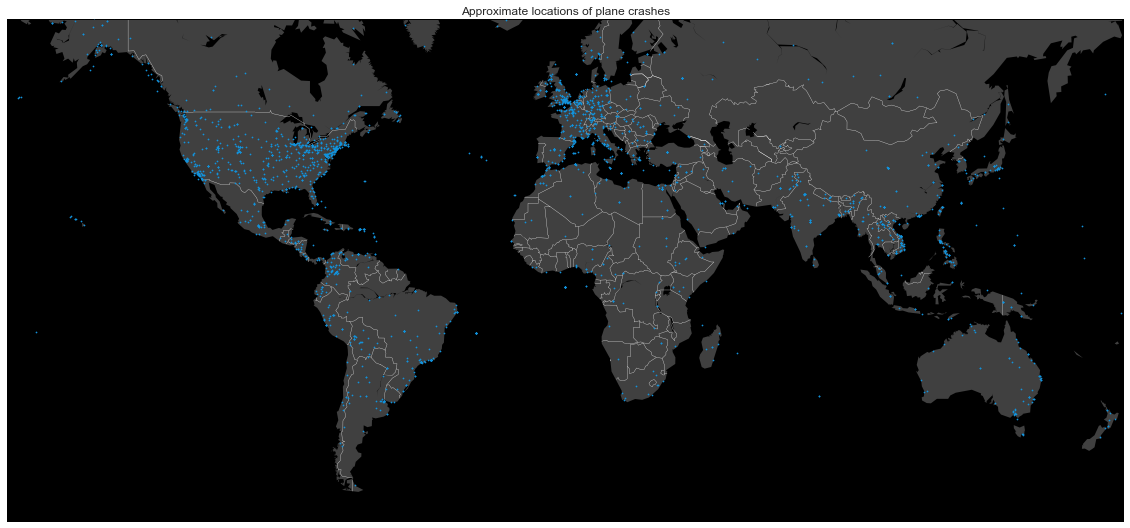

In [13]:
base_map = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=65, llcrnrlon=-180, urcrnrlon=180)

plt.figure(figsize=(20, 10))
    
base_map.fillcontinents(color='#404040', lake_color='#000000')
base_map.drawmapboundary(fill_color='#000000')
base_map.drawcountries(linewidth=0.3, color="w")

mxy = base_map(lng_list, lat_list)
base_map.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=1, zorder=5)

plt.title("Approximate locations of plane crashes")
plt.show()